In [2]:
# импортируем
import lightgbm as lgb
from lightgbm import LGBMClassifier
from lightgbm import plot_metric
from lightgbm import plot_importance
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np
from tqdm import tqdm

In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df = pd.concat([df_train, df_test])
data_tt = pd.read_csv('../df_seminar_logreg_hw.csv')

In [4]:
features_obj = [
    'gender_cd',
    'marital_status_cd',
    'job_type_cd',
    'education_level_cd',

]
# приведем категориальные фичи к одному типу данных для внедрения в модель
for c in features_obj:
    col_type = df[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        df[c] = df[c].astype('category')

for c in features_obj:
    col_type = data_tt[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        data_tt[c] = data_tt[c].astype('category')

In [5]:
# техническое поле - месяц прихода заявки в систему
df['month_dt'] = df['crm_income_dt'].astype('datetime64[M]')
df['month_dt'] = pd.to_datetime(df['month_dt'])


df = pd.get_dummies(df,
                   prefix='bki_flg_',
                   dummy_na=True,
                   columns=['bki_flg'])

                   
df = pd.get_dummies(df,
                   prefix='no_due_and_short_history_flg_',
                   dummy_na=True,
                   columns=['no_due_and_short_history_flg'])


df = pd.get_dummies(df,
                   prefix='mfo_flg_',
                   dummy_na=True,
                   columns=['mfo_flg'])

df = pd.get_dummies(df,
                   prefix='num_fresh_mfo_',
                   dummy_na=True,
                   columns=['num_fresh_mfo'])

df = pd.get_dummies(df,
                   prefix='num_month_to_due_',
                   dummy_na=True,
                   columns=['num_month_to_due'])   

# заведем новый признак
df['age_younger_23'] = np.clip(df['age'], 18, 23)

test_mask = (df.month_dt >= '2019-07-01') & (df.month_dt <= '2019-12-01')
validation_mask = (df.month_dt >= '2019-05-01') & (df.month_dt <= '2019-06-01')

df['sample_part'] = 'Train'
df.loc[validation_mask, 'sample_part'] = 'Validation'
df.loc[test_mask, 'sample_part'] = 'Test'

df['sample_part'].value_counts()

Test          123819
Train         116151
Validation     16916
Name: sample_part, dtype: int64

In [6]:
# техническое поле - месяц прихода заявки в систему
data_tt['month_dt'] = data_tt['crm_income_dt'].astype('datetime64[M]')
data_tt['month_dt'] = pd.to_datetime(data_tt['month_dt'])


data_tt = pd.get_dummies(data_tt,
                   prefix='bki_flg_',
                   dummy_na=True,
                   columns=['bki_flg'])

                   
data_tt = pd.get_dummies(data_tt,
                   prefix='no_due_and_short_history_flg_',
                   dummy_na=True,
                   columns=['no_due_and_short_history_flg'])


data_tt = pd.get_dummies(data_tt,
                   prefix='mfo_flg_',
                   dummy_na=True,
                   columns=['mfo_flg'])

data_tt = pd.get_dummies(data_tt,
                   prefix='num_fresh_mfo_',
                   dummy_na=True,
                   columns=['num_fresh_mfo'])

data_tt = pd.get_dummies(data_tt,
                   prefix='num_month_to_due_',
                   dummy_na=True,
                   columns=['num_month_to_due'])  

# заведем новый признак
data_tt['age_younger_23'] = np.clip(data_tt['age'], 18, 23)

test_mask = (data_tt.month_dt >= '2019-07-01') & (data_tt.month_dt <= '2019-12-01')
validation_mask = (data_tt.month_dt >= '2019-05-01') & (data_tt.month_dt <= '2019-06-01')

data_tt['sample_part'] = 'Train'
data_tt.loc[validation_mask, 'sample_part'] = 'Validation'
data_tt.loc[test_mask, 'sample_part'] = 'Test'

data_tt['sample_part'].value_counts()

Train         116151
Test           61299
Validation     16916
Name: sample_part, dtype: int64

In [7]:
feature_for_processing = [
    'due_chance',
    'balance_sum',
    'num_status_no_due',
    'outstanding_rate',
    'debet_score',
    'bki_score',
    'partner1_score', # только отрицательные значения
    'telecom1_score', # только отрицательные значения
    'telecom2_score'
]

In [8]:
import itertools

df[feature_for_processing] = df[feature_for_processing].fillna(df[feature_for_processing].median())
data_tt[feature_for_processing] = data_tt[feature_for_processing].fillna(data_tt[feature_for_processing].median())

param_grid_list = list(itertools.combinations([['due_chance'],
                                               ['balance_sum'],
                                               ['num_status_no_due'],
                                               ['outstanding_rate'],
                                               ['debet_score'],
                                               ['bki_score'],
                                               ['partner1_score'],
                                               ['telecom1_score'],
                                               ['telecom2_score']
], 2))

In [9]:
df[['log_due_chance',
    'log_balance_sum',
    'log_num_status_no_due',
    'log_outstanding_rate',
    'log_debet_score',
    'log_bki_score',
    'log_partner1_score',
    'log_telecom1_score',
    'log_telecom2_score']] = np.log1p(abs(df[feature_for_processing]))

data_tt[['log_due_chance',
    'log_balance_sum',
    'log_num_status_no_due',
    'log_outstanding_rate',
    'log_debet_score',
    'log_bki_score',
    'log_partner1_score',
    'log_telecom1_score',
    'log_telecom2_score']] = np.log1p(abs(data_tt[feature_for_processing]))

ab      
a / b       
(a + b) / a     
a / (a + b)     
взять сделать log(abs(x))       
взять сделать log(abs(x + 1))       
.       
.       
.       


In [10]:
for params in tqdm(param_grid_list):
    df[str(str(params[0])[2:-2] + '_DIV_' + str(params[1])[2:-2])] = np.array(df[params[0]]).reshape([df.shape[0]]) / (np.array(df[params[1]]).reshape([df.shape[0]]))
    data_tt[str(str(params[0])[2:-2] + '_DIV_' + str(params[1])[2:-2])] = np.array(data_tt[params[0]]).reshape([data_tt.shape[0]]) / (np.array(data_tt[params[1]]).reshape([data_tt.shape[0]]))

100%|██████████| 36/36 [00:09<00:00,  3.80it/s]


In [11]:
for params in tqdm(param_grid_list):
    df[str('log1p' + str(params[0])[2:-2] + '_DIV_' + str(params[1])[2:-2])] = np.log1p(abs(np.array(df[params[0]]).reshape([df.shape[0]]) / (np.array(df[params[1]]).reshape([df.shape[0]]))))
    data_tt[str('log1p' + str(params[0])[2:-2] + '_DIV_' + str(params[1])[2:-2])] = np.log1p(abs(np.array(data_tt[params[0]]).reshape([data_tt.shape[0]]) / (np.array(data_tt[params[1]]).reshape([data_tt.shape[0]]))))

100%|██████████| 36/36 [00:20<00:00,  1.74it/s]


In [12]:
for params in tqdm(param_grid_list):
    df[str(str(params[0])[2:-2] + '_MUL_' + str(params[1])[2:-2])] = np.array(df[params[0]]).reshape([df.shape[0]]) * (np.array(df[params[1]]).reshape([df.shape[0]]))
    data_tt[str(str(params[0])[2:-2] + '_MUL_' + str(params[1])[2:-2])] = np.array(data_tt[params[0]]).reshape([data_tt.shape[0]]) * (np.array(data_tt[params[1]]).reshape([data_tt.shape[0]]))

100%|██████████| 36/36 [00:26<00:00,  1.37it/s]


In [13]:
for params in tqdm(param_grid_list):
    df[str('log1p' + str(params[0])[2:-2] + '_MUL_' + str(params[1])[2:-2])] = np.log1p(abs(np.array(df[params[0]]).reshape([df.shape[0]]) * (np.array(df[params[1]]).reshape([df.shape[0]]))))
    data_tt[str('log1p' + str(params[0])[2:-2] + '_MUL_' + str(params[1])[2:-2])] = np.log1p(abs(np.array(data_tt[params[0]]).reshape([data_tt.shape[0]]) * (np.array(data_tt[params[1]]).reshape([data_tt.shape[0]]))))

100%|██████████| 36/36 [00:40<00:00,  1.13s/it]


##### Обучение модели

In [14]:
'''
params = {
    'boosting_type': 'gbdt', # параметр по умолчанию
    'n_estimators': 5000, # 5000 деревьев
    'learning_rate': 0.00846892854518144,
    'num_leaves': 51, # деревья из 3ех листьев
    'reg_alpha': 39.834968924050166,
    'reg_lambda': 84.86150291406494,
    'subsample_freq': 0, # без положительного subsample_freq подвыборки браться не будут!
    'subsample': 1, # используем всю выборку
    'n_jobs': 4, # обучаемся на 4 ядрах
    'random_state': 4242 # для воспроизводимости результата
}


boosting = LGBMClassifier(**params)
'''

"\nparams = {\n    'boosting_type': 'gbdt', # параметр по умолчанию\n    'n_estimators': 5000, # 5000 деревьев\n    'learning_rate': 0.00846892854518144,\n    'num_leaves': 51, # деревья из 3ех листьев\n    'reg_alpha': 39.834968924050166,\n    'reg_lambda': 84.86150291406494,\n    'subsample_freq': 0, # без положительного subsample_freq подвыборки браться не будут!\n    'subsample': 1, # используем всю выборку\n    'n_jobs': 4, # обучаемся на 4 ядрах\n    'random_state': 4242 # для воспроизводимости результата\n}\n\n\nboosting = LGBMClassifier(**params)\n"

In [15]:
params = {
    'boosting_type': 'gbdt', # параметр по умолчанию
    'n_estimators': 5000, # 5000 деревьев
    'learning_rate': 0.05665229811400253,
    'num_leaves': 18, # деревья из 3ех листьев
    'reg_alpha': 12.490690707542772,
    'reg_lambda': 82.913989266283,
    'subsample_freq': 0, # без положительного subsample_freq подвыборки браться не будут!
    'subsample': 1, # используем всю выборку
    'n_jobs': 4, # обучаемся на 4 ядрах
    'random_state': 4242 # для воспроизводимости результата
}

boosting = LGBMClassifier(**params)

In [16]:
features = list(df.drop(['Id', 'sample_part', 'crm_income_dt', 'month_dt', 'd4p12', 'Id', 'num_fresh_mfo__28.0', 'num_fresh_mfo__29.0', 'num_fresh_mfo__30.0', 'num_fresh_mfo__34.0'], axis=1).columns)
X_train, y_train = df[df.sample_part == 'Train'][features], df[df.sample_part == 'Train']['d4p12']
X_val, y_val = df[df.sample_part == 'Validation'][features], df[df.sample_part == 'Validation']['d4p12']

boosting.fit(
    X=X_train,
    y=y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_metric='auc', 
    callbacks=[lgb.early_stopping(stopping_rounds=100, first_metric_only=True),
              lgb.log_evaluation(50)]
)

/home/chingisbadmaev/.local/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/chingisbadmaev/.local/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.744331	training's binary_logloss: 0.284763	valid_1's auc: 0.691562	valid_1's binary_logloss: 0.270652
[100]	training's auc: 0.756739	training's binary_logloss: 0.278982	valid_1's auc: 0.699902	valid_1's binary_logloss: 0.268541
[150]	training's auc: 0.764053	training's binary_logloss: 0.276088	valid_1's auc: 0.703023	valid_1's binary_logloss: 0.268006
[200]	training's auc: 0.769481	training's binary_logloss: 0.274109	valid_1's auc: 0.704119	valid_1's binary_logloss: 0.267812
[250]	training's auc: 0.773787	training's binary_logloss: 0.272579	valid_1's auc: 0.704318	valid_1's binary_logloss: 0.267842
[300]	training's auc: 0.778213	training's binary_logloss: 0.271108	valid_1's auc: 0.704762	valid_1's binary_logloss: 0.267796
[350]	training's auc: 0.782219	training's binary_logloss: 0.26976	valid_1's auc: 0.705006	valid_1's binary_logloss: 0.267766
[400]	training's auc: 0.785689	training's binary_logloss: 

LGBMClassifier(learning_rate=0.05665229811400253, n_estimators=5000, n_jobs=4,
               num_leaves=18, random_state=4242, reg_alpha=12.490690707542772,
               reg_lambda=82.913989266283, subsample=1)

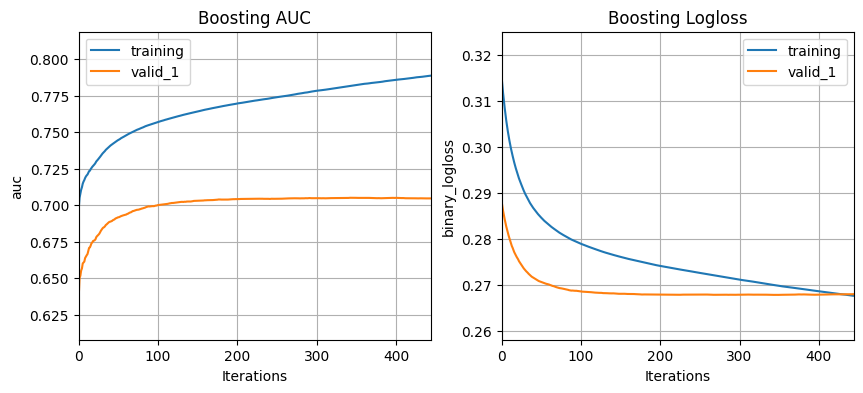

In [17]:
fig, ax = plt.subplots(figsize=(10, 4), nrows=1, ncols=2)

plot_metric(
    boosting,
    metric='auc',
    dataset_names=['training', 'valid_1'],
    ax=ax[0],
    title='Boosting AUC')
plot_metric(
    boosting,
    metric='binary_logloss',
    dataset_names=['training', 'valid_1'],
    ax=ax[1],
    title='Boosting Logloss')
plt.show()

In [18]:
X_test, y_test = df[df.sample_part == 'Test'][features], df[df.sample_part == 'Test']['d4p12']
y_pred = boosting.predict_proba(X_test)
print(np.sum(y_pred))
print(len(y_pred))

123819.0
123819


In [19]:
df_pred = pd.DataFrame(data={'pd': y_pred[:, 1]})
df_pred.index = df_test['Id']

In [20]:
X_test_tt, y_test_tt = data_tt[data_tt.sample_part == 'Test'][features], data_tt[data_tt.sample_part == 'Test']['d4p12']
y_pred_tt = boosting.predict(X_test_tt)
roc_auc_ans = roc_auc_score(df_pred.loc[list(y_test_tt.index)]['pd'].apply(lambda x: round(x)), y_test_tt)
print('roc_auc_score', roc_auc_ans)

roc_auc_score 0.8224211567649952


In [21]:
list(pd.DataFrame({'Value':boosting.feature_importances_,'Feature':features}).sort_values(by="Value",ascending=False)['Feature'])

['age',
 'marital_status_cd',
 'request_amt',
 'num_active_credits',
 'partner1_score_DIV_telecom1_score',
 'job_type_cd',
 'log1pdebet_score_MUL_partner1_score',
 'due_chance_MUL_num_status_no_due',
 'num_status_no_due_DIV_telecom2_score',
 'outstanding_rate_MUL_bki_score',
 'due_chance_MUL_balance_sum',
 'balance_sum_DIV_num_status_no_due',
 'debet_score_MUL_bki_score',
 'debet_score_MUL_partner1_score',
 'log1pbki_score_MUL_partner1_score',
 'log1poutstanding_rate_MUL_partner1_score',
 'due_chance_MUL_telecom2_score',
 'outstanding_rate_MUL_telecom2_score',
 'debet_score_DIV_telecom2_score',
 'outstanding_rate_MUL_partner1_score',
 'debet_score_DIV_partner1_score',
 'bki_score_MUL_telecom2_score',
 'outstanding_rate_DIV_bki_score',
 'education_level_cd',
 'due_chance_DIV_outstanding_rate',
 'bki_score_DIV_telecom2_score',
 'debet_score_DIV_bki_score',
 'partner1_score',
 'due_chance_MUL_outstanding_rate',
 'log1poutstanding_rate_DIV_telecom1_score',
 'balance_sum_MUL_num_status_no_d

In [22]:
best_features = list(pd.DataFrame({'Value':boosting.feature_importances_,'Feature':features}).sort_values(by="Value",ascending=False).head(30)['Feature'])
best_features_boosting = LGBMClassifier(**params)

In [23]:
df_new = pd.DataFrame()
df_new[best_features] = df[best_features]
X_train, y_train = df[df.sample_part == 'Train'][best_features], df[df.sample_part == 'Train']['d4p12']
X_val, y_val = df[df.sample_part == 'Validation'][best_features], df[df.sample_part == 'Validation']['d4p12']

best_features_boosting.fit(
    X=X_train,
    y=y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_metric='auc', 
    callbacks=[lgb.early_stopping(stopping_rounds=100, first_metric_only=True),
              lgb.log_evaluation(50)]
)

/home/chingisbadmaev/.local/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/chingisbadmaev/.local/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.740922	training's binary_logloss: 0.285686	valid_1's auc: 0.686225	valid_1's binary_logloss: 0.271594
[100]	training's auc: 0.75101	training's binary_logloss: 0.280617	valid_1's auc: 0.69378	valid_1's binary_logloss: 0.269859
[150]	training's auc: 0.757185	training's binary_logloss: 0.278181	valid_1's auc: 0.696858	valid_1's binary_logloss: 0.26943
[200]	training's auc: 0.762005	training's binary_logloss: 0.276478	valid_1's auc: 0.698101	valid_1's binary_logloss: 0.269241
[250]	training's auc: 0.766126	training's binary_logloss: 0.275063	valid_1's auc: 0.698176	valid_1's binary_logloss: 0.269315
[300]	training's auc: 0.769881	training's binary_logloss: 0.273855	valid_1's auc: 0.698575	valid_1's binary_logloss: 0.269269
[350]	training's auc: 0.77315	training's binary_logloss: 0.272747	valid_1's auc: 0.698617	valid_1's binary_logloss: 0.269327
[400]	training's auc: 0.776105	training's binary_logloss: 0.2

LGBMClassifier(learning_rate=0.05665229811400253, n_estimators=5000, n_jobs=4,
               num_leaves=18, random_state=4242, reg_alpha=12.490690707542772,
               reg_lambda=82.913989266283, subsample=1)

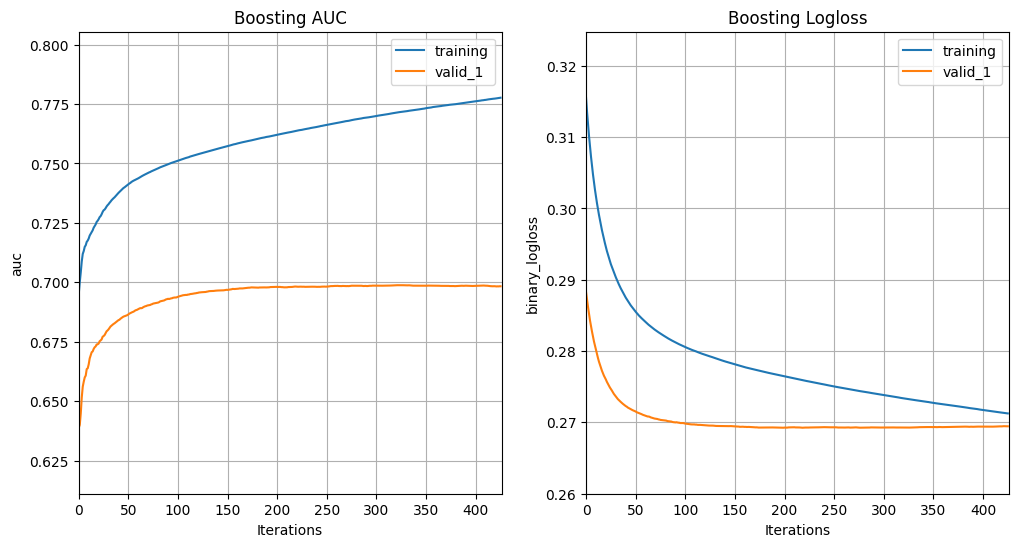

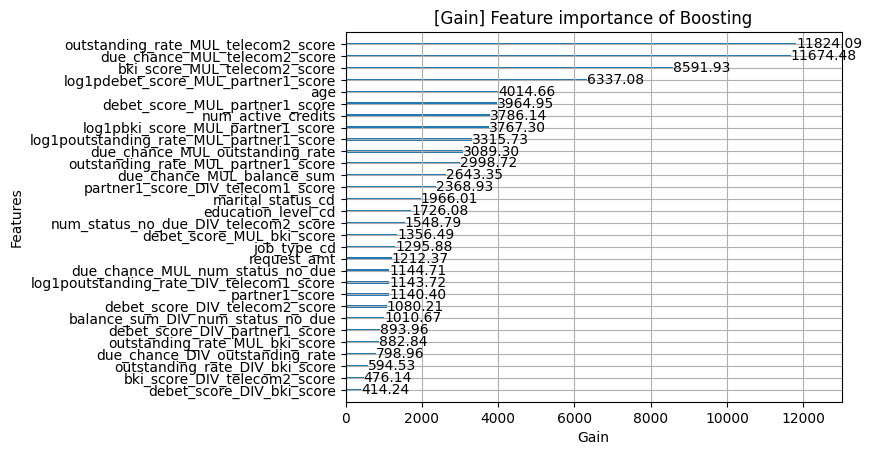

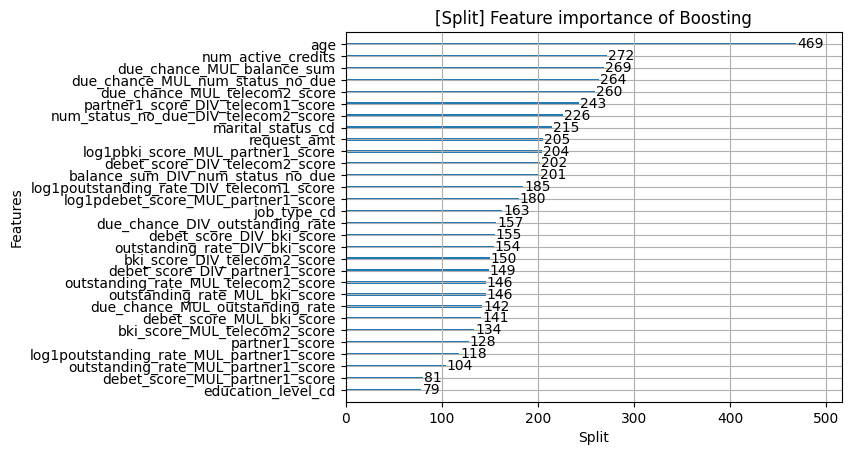

In [24]:

fig, ax = plt.subplots(figsize=(12, 6), nrows=1, ncols=2)

plot_metric(
    best_features_boosting,
    metric='auc',
    dataset_names=['training', 'valid_1'],
    ax=ax[0],
    title='Boosting AUC')
plot_metric(
    best_features_boosting,
    metric='binary_logloss',
    dataset_names=['training', 'valid_1'],
    ax=ax[1],
    title='Boosting Logloss')
plt.show()

plot_importance(
    best_features_boosting,
    title='[Gain] Feature importance of Boosting',
    importance_type='gain',
    xlabel='Gain',
    ylabel='Features',
    grid=True,
    precision=2
)
plt.show()

plot_importance(
    best_features_boosting,
    title='[Split] Feature importance of Boosting',
    importance_type='split',
    xlabel='Split',
    ylabel='Features',
    grid=True,
    precision=2
)
plt.show()

In [25]:
1-1

0

/tmp/ipykernel_27765/3282156350.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.loc[df.sample_part == 'Train', best_features].corr()


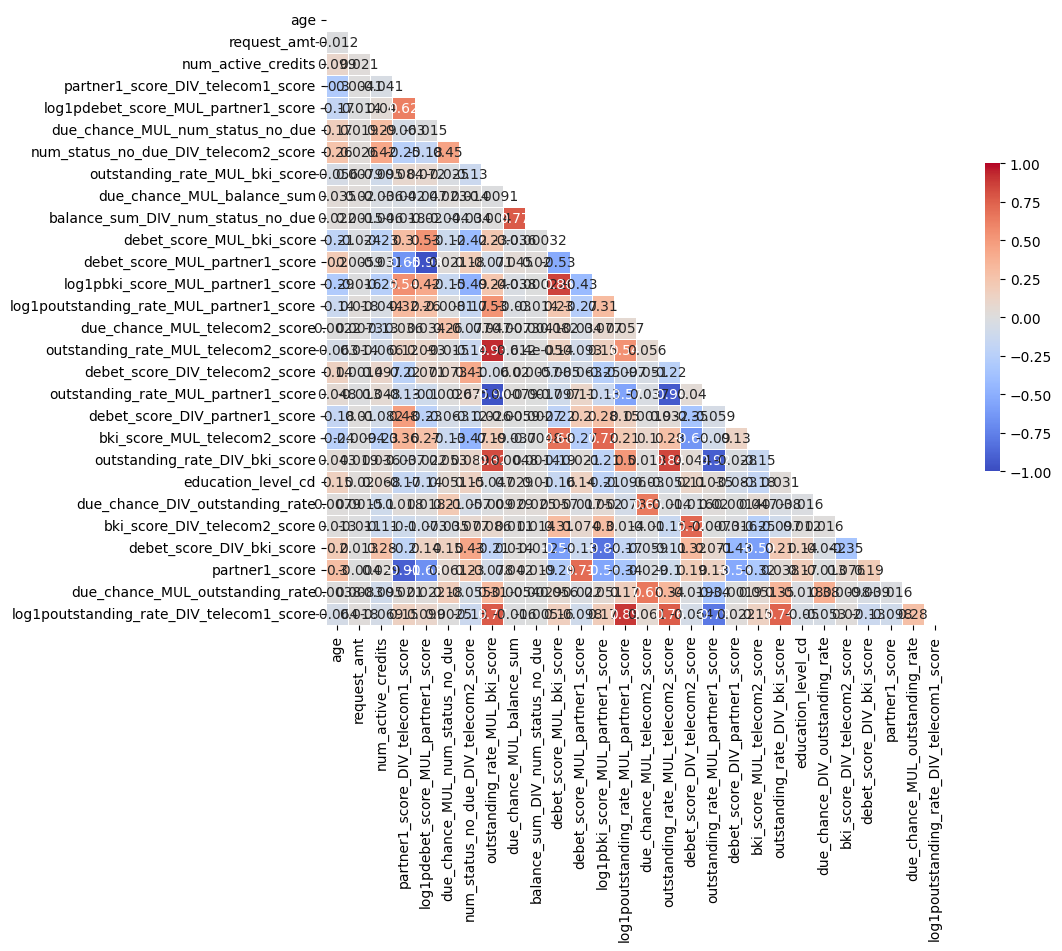

In [26]:
import seaborn as sns
corr = df.loc[df.sample_part == 'Train', best_features].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0,
            linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

### Качетсво моделей во времени

In [27]:
data_tt['pd_boosting'] = boosting.predict_proba(data_tt[features])[:, 1]
data_tt['pd_best_features_boosting'] = best_features_boosting.predict_proba(data_tt[best_features])[:, 1]

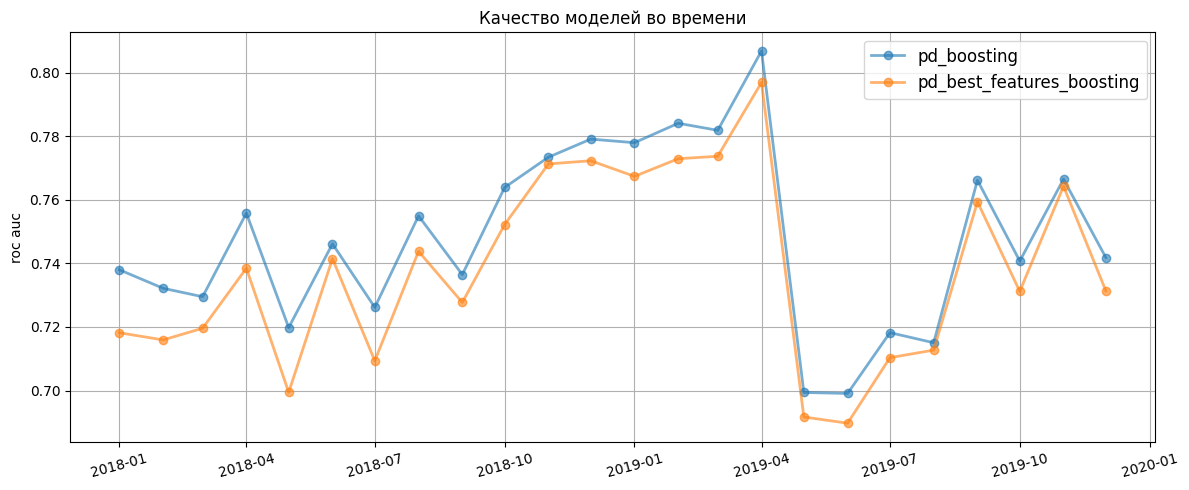

,pd_boosting,pd_best_features_boosting
2018-01-01,0.737986,0.718181
2018-02-01,0.732167,0.715927
2018-03-01,0.729508,0.719589
2018-04-01,0.755794,0.738483
2018-05-01,0.719797,0.699452
2018-06-01,0.746150,0.741486
2018-07-01,0.726155,0.709361
2018-08-01,0.754943,0.743784
2018-09-01,0.736467,0.727716
2018-10-01,0.763873,0.752202


In [28]:
from model_tools import plot_metric_time
plot_metric_time(
    df=data_tt,
    features=['pd_boosting', 'pd_best_features_boosting'],
    target='d4p12',
    time='month_dt',
    ttl='Качество моделей во времени'
)

### ЕЩЕ одна модель

In [29]:
params = {
    'boosting_type': 'gbdt', # параметр по умолчанию
    'n_estimators': 5000, # 5000 деревьев
    'learning_rate': 0.00846892854518144,
    'num_leaves': 51, # деревья из 3ех листьев
    'reg_alpha': 39.834968924050166,
    'reg_lambda': 84.86150291406494,
    'subsample_freq': 0, # без положительного subsample_freq подвыборки браться не будут!
    'subsample': 1, # используем всю выборку
    'n_jobs': 4, # обучаемся на 4 ядрах
    'random_state': 4242 # для воспроизводимости результата
}


boosting2 = LGBMClassifier(**params)


In [30]:
features = list(df.drop(['Id', 'sample_part', 'crm_income_dt', 'month_dt', 'd4p12', 'Id', 'num_fresh_mfo__28.0', 'num_fresh_mfo__29.0', 'num_fresh_mfo__30.0', 'num_fresh_mfo__34.0'], axis=1).columns)
X_train, y_train = df[df.sample_part == 'Train'][features], df[df.sample_part == 'Train']['d4p12']
X_val, y_val = df[df.sample_part == 'Validation'][features], df[df.sample_part == 'Validation']['d4p12']

boosting2.fit(
    X=X_train,
    y=y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_metric='auc', 
    callbacks=[lgb.early_stopping(stopping_rounds=100, first_metric_only=True),
              lgb.log_evaluation(50)]
)features

/home/chingisbadmaev/.local/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/chingisbadmaev/.local/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.726481	training's binary_logloss: 0.304941	valid_1's auc: 0.666866	valid_1's binary_logloss: 0.282151
[100]	training's auc: 0.733612	training's binary_logloss: 0.297423	valid_1's auc: 0.674518	valid_1's binary_logloss: 0.277894
[150]	training's auc: 0.739579	training's binary_logloss: 0.292413	valid_1's auc: 0.680653	valid_1's binary_logloss: 0.275083
[200]	training's auc: 0.744624	training's binary_logloss: 0.288832	valid_1's auc: 0.685127	valid_1's binary_logloss: 0.273197
[250]	training's auc: 0.748992	training's binary_logloss: 0.286137	valid_1's auc: 0.688478	valid_1's binary_logloss: 0.271899
[300]	training's auc: 0.753028	training's binary_logloss: 0.283917	valid_1's auc: 0.691704	valid_1's binary_logloss: 0.270881
[350]	training's auc: 0.756224	training's binary_logloss: 0.282213	valid_1's auc: 0.693594	valid_1's binary_logloss: 0.270218
[400]	training's auc: 0.758849	training's binary_logloss:

LGBMClassifier(learning_rate=0.00846892854518144, n_estimators=5000, n_jobs=4,
               num_leaves=51, random_state=4242, reg_alpha=39.834968924050166,
               reg_lambda=84.86150291406494, subsample=1)

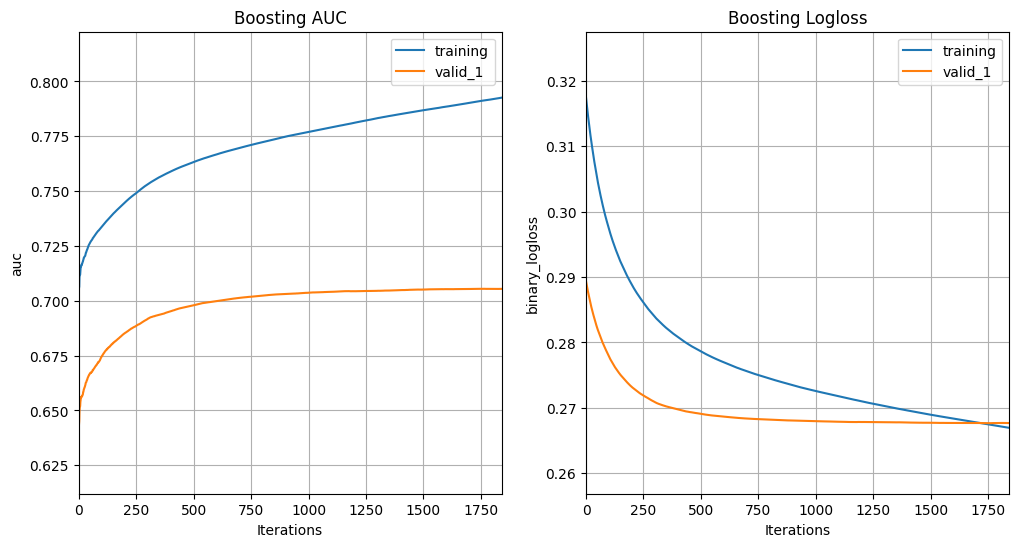

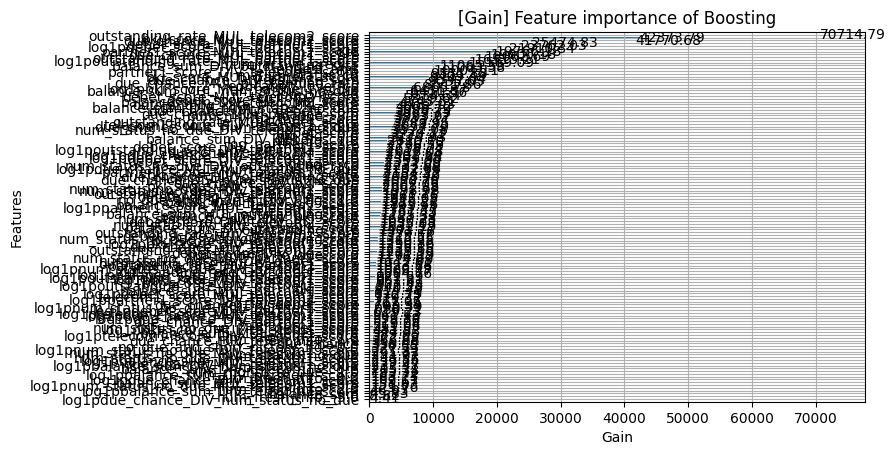

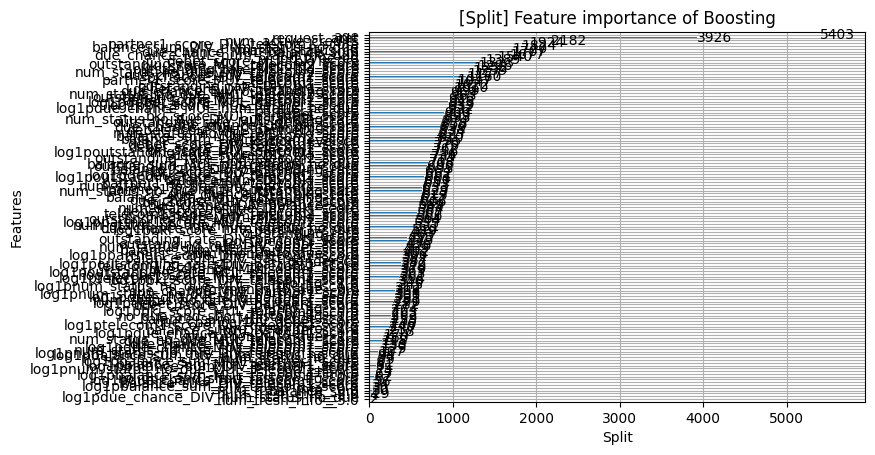

In [31]:

fig, ax = plt.subplots(figsize=(12, 6), nrows=1, ncols=2)

plot_metric(
    boosting2,
    metric='auc',
    dataset_names=['training', 'valid_1'],
    ax=ax[0],
    title='Boosting AUC')
plot_metric(
    boosting2,
    metric='binary_logloss',
    dataset_names=['training', 'valid_1'],
    ax=ax[1],
    title='Boosting Logloss')
plt.show()

plot_importance(
    boosting2,
    title='[Gain] Feature importance of Boosting',
    importance_type='gain',
    xlabel='Gain',
    ylabel='Features',
    grid=True,
    precision=2
)
plt.show()

plot_importance(
    boosting2,
    title='[Split] Feature importance of Boosting',
    importance_type='split',
    xlabel='Split',
    ylabel='Features',
    grid=True,
    precision=2
)
plt.show()

In [32]:
data_tt['pd_boosting'] = boosting.predict_proba(data_tt[features])[:, 1]
data_tt['pd_best_features_boosting'] = best_features_boosting.predict_proba(data_tt[best_features])[:, 1]
data_tt['boosting2'] = boosting2.predict_proba(data_tt[features])[:, 1]

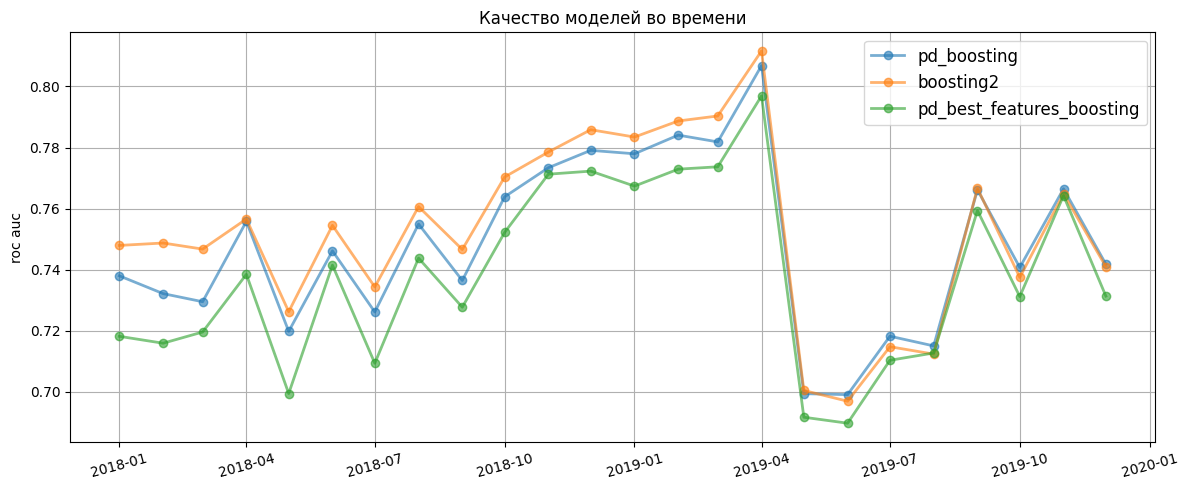

,pd_boosting,boosting2,pd_best_features_boosting
2018-01-01,0.737986,0.747941,0.718181
2018-02-01,0.732167,0.748733,0.715927
2018-03-01,0.729508,0.746740,0.719589
2018-04-01,0.755794,0.756587,0.738483
2018-05-01,0.719797,0.726244,0.699452
2018-06-01,0.746150,0.754512,0.741486
2018-07-01,0.726155,0.734349,0.709361
2018-08-01,0.754943,0.760645,0.743784
2018-09-01,0.736467,0.746613,0.727716
2018-10-01,0.763873,0.770356,0.752202


In [33]:
from model_tools import plot_metric_time
plot_metric_time(
    df=data_tt,
    features=['pd_boosting', 'boosting2', 'pd_best_features_boosting'],
    target='d4p12',
    time='month_dt',
    ttl='Качество моделей во времени'
)

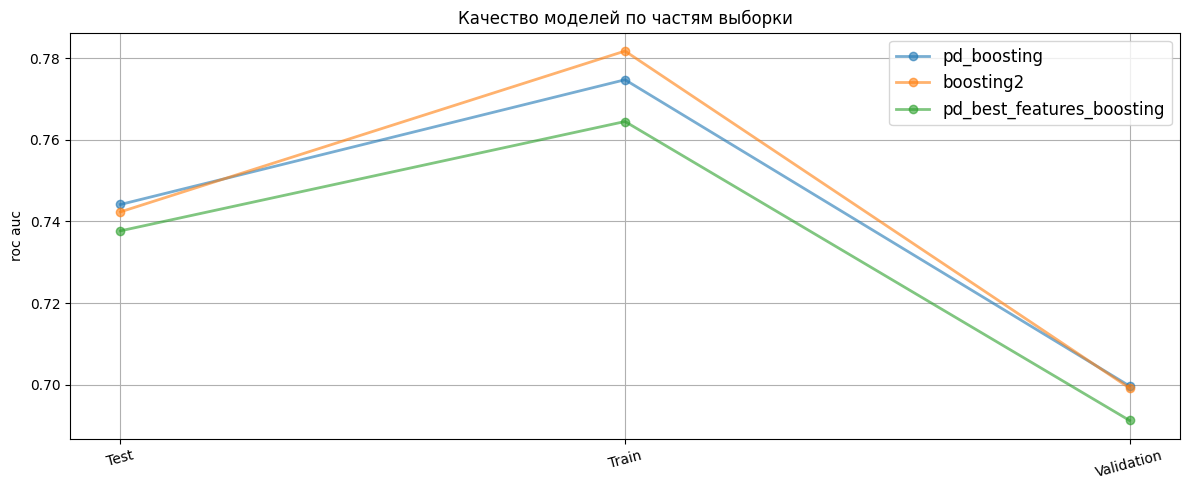

,pd_boosting,boosting2,pd_best_features_boosting
Test,0.744,0.742,0.738
Train,0.775,0.782,0.764
Validation,0.700,0.699,0.691


In [34]:
plot_metric_time(
    df=data_tt,
    features=['pd_boosting', 'boosting2', 'pd_best_features_boosting'],
    target='d4p12',
    time='sample_part',
    ttl='Качество моделей по частям выборки'
).round(3)

#### SHAP

In [35]:
import joblib
import shap

/home/chingisbadmaev/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [36]:
explainer = shap.TreeExplainer(best_features_boosting)
shap_values = explainer.shap_values(df[best_features])

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [39]:
shap.initjs()

In [40]:
shap.force_plot(explainer.expected_value[1], shap_values[1][0, :], df[best_features].iloc[0, :])

In [41]:
shap.force_plot(explainer.expected_value[1], shap_values[1][42, :], df[best_features].iloc[42, :])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


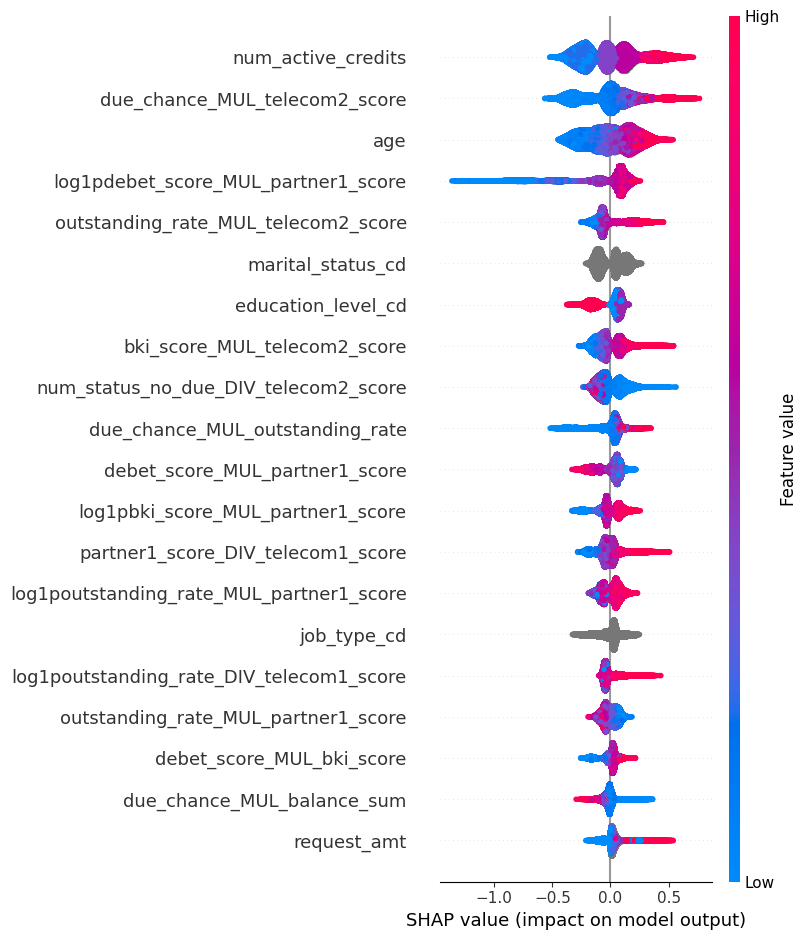

In [44]:
shap.summary_plot(shap_values[1], df[best_features])

In [48]:
df['due_chance_MUL_telecom2_score']

0         0.569916
1         0.063897
2         0.024253
3         0.052763
4         0.203917
            ...   
123814    0.144177
123815    0.159894
123816    0.439513
123817    0.337042
123818    1.943537
Name: due_chance_MUL_telecom2_score, Length: 256886, dtype: float64